In [38]:
# Jun Tu 21-732-722
# Guanda Zhao 21-716-345

In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as sts

In [40]:
data_base_path = "Data/"

cormat_1h = np.load(data_base_path + "cormat_1h.npy")
cormat_1m = np.load(data_base_path + "cormat_1m.npy")
stocknames = np.loadtxt(data_base_path + "stocknames.txt", dtype=str)
stocknames_dict = {}

for i in range(0, len(stocknames)):
    stocknames_dict[i] = stocknames[i]

print("Loading is done")

## thread unsafe
figure_uni_index=0
def new_figure():
    global figure_uni_index
    figure_uni_index = figure_uni_index + 1
    fig = plt.figure(figure_uni_index)
    return fig


Loading is done


In [41]:
def lambda_min_max(Q):
    lambda_min = 1 + 1 / Q - 2 * math.sqrt(1/Q)
    lambda_max = 1 + 1 / Q + 2 * math.sqrt(1/Q)
    return lambda_min, lambda_max

def marcenko_pastur(Q, lambda_input):
    lambda_min, lambda_max = lambda_min_max(Q)
    probability = (Q / (2 * math.pi)) * (math.sqrt((lambda_max - lambda_input)*(lambda_input - lambda_min)) / lambda_input)
    return probability

def replace_noise(eigvals, norm_noise, noise_index):
    matrix = np.zeros((eigvals.shape[0], eigvals.shape[0]))
    for i in range(0, eigvals.shape[0]):
        matrix[i][i] = eigvals[i]
    for i in range(len(noise_index)):
        nidx = noise_index[i]
        matrix[nidx][nidx] = norm_noise[i]
    return matrix

### A07.01

eigenvalues and vectors for 1m matrix
[30.15967999  3.06441856  2.69300287  2.01853023  1.87088218  1.61804659
  1.5286698   1.44483891  1.3705737   1.21522435  1.20763077  1.18148502
  1.13456249  1.12095821  1.09757579  1.04829675  1.02094271  0.07619294
  0.11351842  0.99073481  0.95252709  0.94956666  0.13593653  0.92901798
  0.9060765   0.89551127  0.17642145  0.18275983  0.87128445  0.85969399
  0.84981126  0.22164492  0.24641848  0.8242317   0.79908457  0.805316
  0.81074884  0.77242311  0.25038788  0.7496294   0.26942891  0.27694144
  0.73472574  0.72888706  0.28200079  0.69964766  0.70444103  0.29220966
  0.29358174  0.30151474  0.68103054  0.67564233  0.3163477   0.32930381
  0.66727062  0.65497874  0.64891423  0.3384005   0.34501027  0.6430286
  0.35174528  0.35579498  0.63541305  0.63714127  0.62493966  0.3615253
  0.61306728  0.36626357  0.5971473   0.37664014  0.38565092  0.5802699
  0.39680543  0.57634413  0.55863149  0.55703092  0.54810024  0.42448627
  0.41284013  0.40

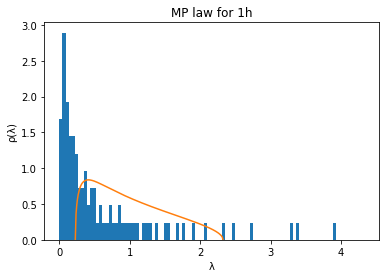

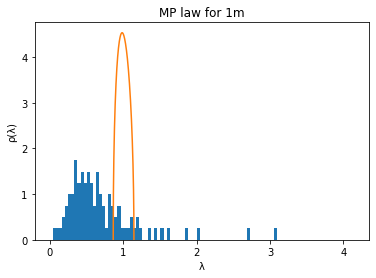

In [42]:
eigval_1h, eigvec_1h = np.linalg.eig(cormat_1h)
eigval_1m, eigvec_1m = np.linalg.eig(cormat_1m)
print("eigenvalues and vectors for 1m matrix")
print (eigval_1m)
print (eigvec_1m)
print("eigenvalues and vectors for 1h matrix")
print (eigval_1h)
print (eigvec_1h)

Q_1h = 3.6289
Q_1m = 200.8969

lambda_min_1h, lambda_max_1h = lambda_min_max(Q_1h)
lambda_min_1m, lambda_max_1m = lambda_min_max(Q_1m)

x_1h = np.arange(lambda_min_1h, lambda_max_1h, (lambda_max_1h - lambda_min_1h)/200)
x_1m = np.arange(lambda_min_1m, lambda_max_1m, (lambda_max_1m - lambda_min_1m)/200)
x_1h = np.append(x_1h, lambda_max_1h)
x_1m = np.append(x_1m, lambda_max_1m)

y_1h = [marcenko_pastur(Q_1h, x) for x in x_1h]
y_1m = [marcenko_pastur(Q_1m, x) for x in x_1m]

new_figure()
plt.xlabel('\u03BB')
plt.ylabel('\u03C1(\u03BB)')
plt.title('MP law for 1h')
plt.hist(eigval_1h, bins=np.linspace(0.0, lambda_max_1h + 2, num=100), density = True)
plt.plot(x_1h, y_1h)

new_figure()
plt.xlabel('\u03BB')
plt.ylabel('\u03C1(\u03BB)')
plt.title('MP law for 1m')
plt.hist(eigval_1m, bins=np.linspace(0.0, lambda_max_1m + 3, num=100), density = True)
plt.plot(x_1m, y_1m)

In [43]:
noise_1h = []
noise_1m = []

noise_1h_idx=[]
for eigval_idx in range(len(eigval_1h)):
    eigval = eigval_1h[eigval_idx]
    if (eigval < lambda_max_1h):
        noise_1h.append(eigval)
        noise_1h_idx.append(eigval_idx)

noise_1m_idx=[]
for eigval_idx in range(len(eigval_1m)):
    eigval = eigval_1m[eigval_idx]
    if (eigval < lambda_max_1m):
        noise_1m.append(eigval)
        noise_1m_idx.append(eigval_idx)

norm_noise_1h = [lambda_i / sum(noise_1h) * len(noise_1h) for lambda_i in noise_1h]
norm_noise_1m = [lambda_i / sum(noise_1m) * len(noise_1m) for lambda_i in noise_1m]

diagonal_1h = replace_noise(eigval_1h, norm_noise_1h, noise_1h_idx)
diagonal_1m = replace_noise(eigval_1m, norm_noise_1m, noise_1m_idx)

denoised_1h = eigvec_1h.dot(diagonal_1h).dot(np.linalg.inv(eigvec_1h))
denoised_1m = eigvec_1m.dot(diagonal_1m).dot(np.linalg.inv(eigvec_1m))

D_1h = np.zeros(denoised_1h.shape)
D_1m = np.zeros(denoised_1m.shape)

for i in range(0, denoised_1h.shape[0]):
    D_1h[i][i] = 1 / math.sqrt(denoised_1h[i][i])
    
for i in range(0, denoised_1m.shape[0]):
    D_1m[i][i] = 1 / math.sqrt(denoised_1m[i][i])

denoised_1h = D_1h.dot(denoised_1h).dot(D_1h)
denoised_1m = D_1m.dot(denoised_1m).dot(D_1m)

print('denoised_1h:\n', denoised_1h)
print('\n')
print('denoised_1m:\n', denoised_1m)

denoised_1h:
 [[1.         0.14692527 0.15940992 ... 0.07201036 0.01421172 0.10200188]
 [0.14692527 1.         0.33724734 ... 0.15917889 0.11284625 0.18945718]
 [0.15940992 0.33724734 1.         ... 0.27913275 0.11432449 0.14112075]
 ...
 [0.07201036 0.15917889 0.27913275 ... 1.         0.26350568 0.27682449]
 [0.01421172 0.11284625 0.11432449 ... 0.26350568 1.         0.35824278]
 [0.10200188 0.18945718 0.14112075 ... 0.27682449 0.35824278 1.        ]]


denoised_1m:
 [[1.         0.12031749 0.19389909 ... 0.16291595 0.19838505 0.20601955]
 [0.12031749 1.         0.14695473 ... 0.12858604 0.1652078  0.26106404]
 [0.19389909 0.14695473 1.         ... 0.12086124 0.18929927 0.22079134]
 ...
 [0.16291595 0.12858604 0.12086124 ... 1.         0.19520453 0.23550205]
 [0.19838505 0.1652078  0.18929927 ... 0.19520453 1.         0.26607777]
 [0.20601955 0.26106404 0.22079134 ... 0.23550205 0.26607777 1.        ]]


### A07.02
#### Scatterplot of the 1 hour vs 1 minute denoisedcorrelations

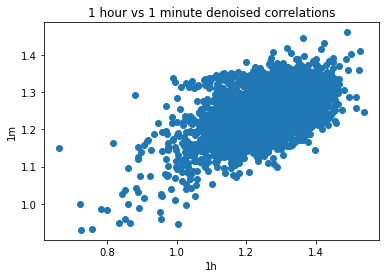

In [44]:
D_1h = np.zeros(cormat_1h.shape)
D_1m = np.zeros(cormat_1m.shape)

for i in range(0, cormat_1h.shape[0]):
    for j in range(0, cormat_1h.shape[1]):
        D_1h[i][j] = math.sqrt(2 * (round(1.0,14) - round(denoised_1h[i][j],14)))

for i in range(0, cormat_1m.shape[0]):
    for j in range(0, cormat_1m.shape[1]):
        D_1m[i][j] = math.sqrt(2 * (round(1.0,14) - round(denoised_1m[i][j],14)))
        
new_figure()
D_1h_utri_flatten=np.triu(D_1h, 0).flatten()
D_1m_utri_flatten=np.triu(D_1m, 0).flatten()
dc_x = np.delete(D_1h_utri_flatten, np.where(D_1h_utri_flatten==0))
dc_y = np.delete(D_1m_utri_flatten, np.where(D_1m_utri_flatten==0))
plt.xlabel('1h')
plt.ylabel('1m')
plt.title('1 hour vs 1 minute denoised correlations')
plt.scatter(x = dc_x, y = dc_y)

In [45]:
G_1h = nx.from_numpy_matrix(D_1h)
G_1m = nx.from_numpy_matrix(D_1m)
nx.set_node_attributes(G_1h, stocknames_dict, 'ticker')
nx.set_node_attributes(G_1m, stocknames_dict, 'ticker')

MST_1h = nx.minimum_spanning_tree(G_1h)
MST_1m = nx.minimum_spanning_tree(G_1m)

degrees_1h = []
degrees_1m = []

MST_1h_degrees = MST_1h.degree()
MST_1m_degrees = MST_1m.degree()
for i in range (0, len(stocknames)):
    degrees_1h.append(MST_1h_degrees[i])
    degrees_1m.append(MST_1m_degrees[i])

#### MST for 1 h

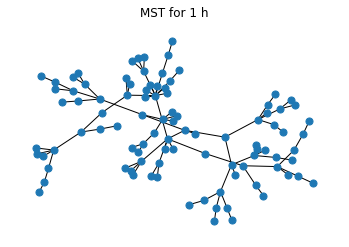

In [46]:
new_figure()
plt.title("MST for 1 h")
nx.draw(MST_1h, node_size=50)

#### MST for 1 m

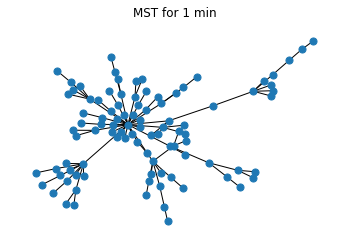

In [47]:
new_figure()
plt.title("MST for 1 min")
nx.draw(MST_1m, node_size=50)

#### Scatterplot of the 1 hour vs 1 minute MST degrees

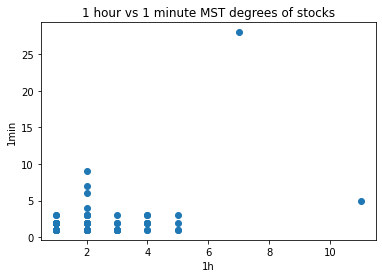

In [48]:
new_figure()
plt.title('1 hour vs 1 minute MST degrees of stocks')
plt.xlabel('1h')
plt.ylabel('1min')
plt.scatter(x = degrees_1h, y = degrees_1m)

#### A07.3
1. There are market modes for both 1h and 1min, Respectively at λ = 31.03 and 30.16.
2. AXP. AXP has the largest correlation to the market。
3. 5 stocks with highest degree on the MST for 1h:  ['DIS', 'HON', 'DVN', 'GD', 'GS']
   5 stocks with highest degree on the MST for 1m:  ['HON', 'EMR', 'JPM', 'COP', 'DIS']
4. Qualitatively similar. See below histgrams, the amounts of low degree and the trends are almost the same.

In [49]:
print("max eigenvalue - 1h:" + str(np.max(eigval_1h)))
print("max eigenvalue - 1m:" + str(np.max(eigval_1m)))

max eigenvalue - 1h:31.02783573849152
max eigenvalue - 1m:30.15967998949906


In [50]:
max_eigenvec_h = eigvec_1m[np.argmax(eigval_1h)]
max_eigenvec_m = eigvec_1m[np.argmax(eigval_1m)]
max_cor_idx_h = np.argmax(np.absolute(max_eigenvec_h))
max_cor_idx_m = np.argmax(np.absolute(max_eigenvec_m))
print("Stock with max correlation to market node:" + G_1h.nodes[max_cor_idx_h]['ticker'])

Stock with max correlation to market node:AXP


In [51]:
top5_degree_1h = sorted(MST_1h_degrees, key=lambda x: x[1], reverse = True)[0:5]
top5_degree_1m = sorted(MST_1m_degrees, key=lambda x: x[1], reverse = True)[0:5]

top5_degree_name_1h = []
top5_degree_name_1m = []

for i in range (0, 5):
    top5_degree_name_1h.append(nx.get_node_attributes(MST_1h, 'ticker')[top5_degree_1h[i][0]])
    top5_degree_name_1m.append(nx.get_node_attributes(MST_1m, 'ticker')[top5_degree_1m[i][0]])

print("5 stocks with highest degree on the MST for 1h: ",top5_degree_name_1h)
print("5 stocks with highest degree on the MST for 1m: ",top5_degree_name_1m)


5 stocks with highest degree on the MST for 1h:  ['DIS', 'HON', 'DVN', 'GD', 'GS']
5 stocks with highest degree on the MST for 1m:  ['HON', 'EMR', 'JPM', 'COP', 'DIS']


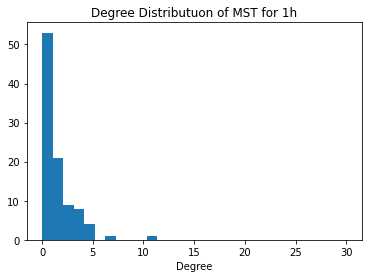

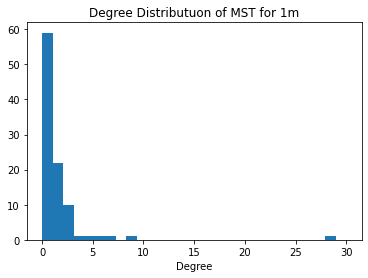

In [52]:
new_figure()
plt.title("Degree Distributuon of MST for 1h")
plt.xlabel("Degree")
plt.hist(degrees_1h, bins=np.linspace(0,30,30))
plt.show()

new_figure()
plt.title("Degree Distributuon of MST for 1m")
plt.xlabel("Degree")
plt.hist(degrees_1m, bins=np.linspace(0,30,30))
plt.show()